# Load pretrained CNN and run on data

In [1]:
from keras.models import load_model
from soapcw import cw 
import soapcw as soap
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np

In [3]:
model = load_model("../../soapcw/cnn/keras/trained_models/O1/O1_vitmap_even.h5")

### Simulate a signal to test on

In [8]:
sig = cw.GenerateSignal()
# define signal parameters
sig.alpha = 3.310726752188296
sig.delta = -0.8824241920781501
sig.cosi = -0.63086
sig.phi0 = 4.007
sig.psi = 0.52563
sig.f = [100.05,-1e-17,0]
sig.tref = 946339148.816094
sig.h0 = 3e-24
# define ephemeredies (optional the default is below)
#sig.earth_ephem = "earth00-19-DE405.dat.gz"
#sig.sun_ephem = "sun00-19-DE405.dat.gz"
sig.earth_ephem = "/home/joseph.bayley/.virtualenvs/soap36/share/lalpulsar/earth00-19-DE405.dat.gz"
sig.earth_ephem = "/home/joseph.bayley/.virtualenvs/soap36/share/lalpulsar/sun00-19-DE405.dat.gz"

In [9]:
# set the spectrogram parameters
nsft, tstart, tsft, flow, fhigh = 22538, 931042949, 1800., 100.0,100.1
snr1 = 110 # signal simulation
snr2 = 0   # noise simulation

In [10]:
#generate the spectrogram with above parameters
spect_sig = sig.get_spectrogram(tstart = tstart, nsft=nsft,tsft=tsft,fmin=flow,fmax=fhigh,dets=["H1","L1"],snr=snr1)

Could not load ephemeris file: /home/joseph.bayley/.virtualenvs/soap36/share/lalpulsar/sun00-19-DE405.dat.gz sun00-19-DE405.dat.gz


OSError: Could not read in ephemeris files: Internal function call failed: Input domain error

In [ ]:
# sum the sfts over 1 day to increase SNR and average out antenna pattern
spect_sig.sum_sfts()

In [ ]:
# generate transition matrix
tr = soap.tools.transition_matrix_2d(1.1,1e400,1e400)

In [ ]:
# run soap on spectrgram with signal simulation
viterbi_sig = soap.two_detector(tr,spect_sig.H1.summed_norm_sft_power,spect_sig.L1.summed_norm_sft_power)

In [13]:
# generate noise spectrogram
spect_noise = sig.get_spectrogram(tstart = tstart, nsft=nsft,tsft=tsft,fmin=flow,fmax=fhigh,dets=["H1","L1"],snr=snr2)
spect_noise.sum_sfts()

In [14]:
# run soap on spectrogram with no signal injected (just noise_)
viterbi_noise = soap.two_detector(tr,spect_noise.H1.summed_norm_sft_power,spect_noise.L1.summed_norm_sft_power)

#### Downsample to same size as the inputs for the pretrained CNN (156x96)

In [15]:
# downsample and normalise the spectrograms
vitmap_sig_resize = resize(viterbi_sig.vitmap, (156,89), anti_aliasing=True)
vitmap_sig_resize = vitmap_sig_resize/vitmap_sig_resize.max()
vitmap_sig_resize = vitmap_sig_resize.reshape(vitmap_sig_resize.shape[0],vitmap_sig_resize.shape[1],1)

In [16]:
vitmap_noise_resize = resize(viterbi_noise.vitmap, (156,89), anti_aliasing=True)
vitmap_noise_resize = vitmap_noise_resize/vitmap_noise_resize.max()
vitmap_noise_resize = vitmap_noise_resize.reshape(vitmap_noise_resize.shape[0],vitmap_noise_resize.shape[1],1)

Text(0, 0.5, 'Frequency index \n (noise)')

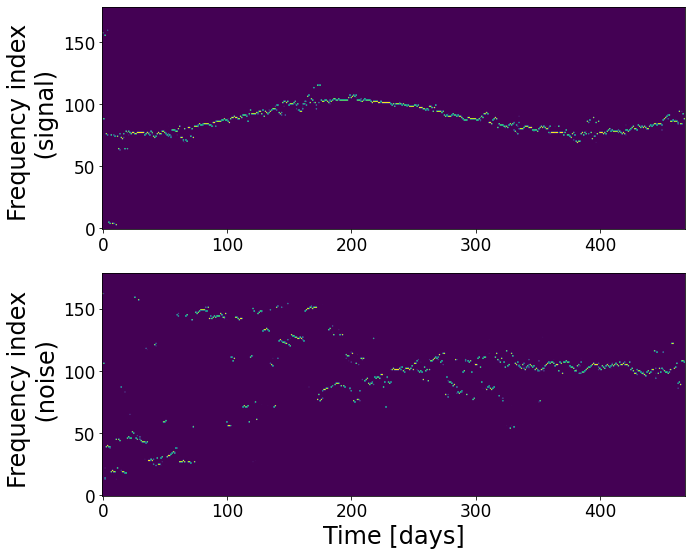

In [27]:
fig, ax = plt.subplots(nrows = 2, figsize = (15,9))
ax[0].imshow(viterbi_sig.vitmap.T,origin="lower")
ax[1].imshow(viterbi_noise.vitmap.T,origin="lower")
ax[0].grid(False)
ax[1].grid(False)
ax[1].set_xlabel("Time [days]")
ax[0].set_ylabel("Frequency index \n (signal)")
ax[1].set_ylabel("Frequency index \n (noise)")

In [19]:
predictions = model.predict(np.array([vitmap_noise_resize,vitmap_sig_resize]))

The predictions are shown for the noise vitmap and the signal vitmap below and will return a values between 0 and 1 and is intended to be used as a detection statistic
 - The noise vitmap gives an output of 0.3
 - The signal vitmap gives and output of 1
 - The false alarm value can be set by testing on many noise examples

In [20]:
predictions

array([[0.30285284],
       [1.        ]], dtype=float32)